In [ ]:
username = 'MarcelloCeresini'
repository = 'QuestionAnswering'

# COLAB ONLY CELLS
try:
    import google.colab
    IN_COLAB = True
    !pip3 install transformers
    !git clone https://www.github.com/{username}/{repository}.git
    #from google.colab import drive
    #drive.mount('/content/drive/')
    %cd /content/QuestionAnswering/src
except:
    IN_COLAB = False

# Description

In this notebook, we will try to implement the architecture detailed in [Dense Passage Retrieval for Open-Domain Question Answering](https://arxiv.org/pdf/2004.04906.pdf). 

The idea is that we have a corpus of documents $C = {p_1, p_2, \dots, p_M}$ where each passage $p_i$ can be viewed as a sequence of tokens $w_1^{(i)}, w_2^{(i)}, \dots, w_{|p_i|}^{(i)}$ and given a question $q$ we want to find the sequence of tokens $w_s^{(i)}, w_{s+1}^{(i)}, \dots, w_{e}^{(i)}$ from one of the passage $i$ that can answer the question.

In order to find the passage $i$ we need an efficient **Retriever** (i.e. a function $R: (q, C) \rightarrow C_F$ where $C_F$ is a very small set of $k$ documents that have a high correlation with the query.)

In the Tf-Idf example, the retriever was simply a function that returned the top 5 scores obtained by computing the vector cosine similarity between the query and all other documents. The problem with this approach is that it is not very efficient. Tf-Idf is a **sparse** document/query representation, thus computing a multitude of dot products between these very long vectors can be expensive.

The paper cited above proposes a **dense** representation instead. It uses a Dense Encoder $E_P$ which maps all paragraphs to $d$-dimensional vectors. These vectors are stored in a database so that they can be efficiently retrieved. 

At run-time, another Dense Encoder is used $E_Q$ which maps the input question to a vector with the same dimensionality $d$. Then, a similarity score is computed between the two representations:

$sim(p,q) = E_Q(q)^\intercal E_P(p)$

In the paper, $E_Q$ and $E_P$ are two independent BERT transformers and the $d$-dimensional vector is the **output at the $\texttt{[CLS]}$ token** (so, $d = 768$).
- This leaves open the possibility to use a larger dimensionality (eg. concatenating the output at multiple blocks like we did for the QA task).

The $d$-dimensional representations of the $M$ passages are indexed using [FAISS](https://github.com/facebookresearch/faiss), an efficient, open-source library for similarity search and clustering of dense vectors developed at Facebook AI. At run-time, we simply compute $v_q = E_Q(q)$ and retrieve the top $k$ passages with embeddings closest to $v_q$.

In this case, training the network means solving a **metric learning** problem: the two BERT networks need to learn an **effective vector space** such that relevant pairs of questions and passages are close, while irrelevant pairs are placed further away. In this problem we usually build a **training instance $D$** as ${(q_i, p_i^+, p_{i,1}^-, p_{i,2}^-, \dots, p_{i,n}^-)}^m_{i=1}$, where question $q$ is paired with a relevant (positive) passage $p_i^+$ and $n$ irrelevant (negative) passages. Then, the loss function is the negative log-likelihood of the positive passage:

$L(q_i, p_i^+, p_{i,1}^-, p_{i,2}^-, \dots, p_{i,n}^-) = -\log\frac{e^{sim(q_i, p_i^+)}}{e^{sim(q_i, p_i^+)} + \sum_{j=1}^n e^{sim(q_i, p_{i,j}^-)}}$

It's easy to find the positive paragraph, but choosing the negatives is quite important. In particular, the paper proposes different ways for sampling the negatives:
- Random: a negative is any random passage in the corpus
- TF-IDF (The paper uses a variant, BM25): the negatives are the top passages (not containing the answer) returned by a TF-IDF search
- Gold: the negatives are positives for other questions in the mini-batch. For the researchers, this is the best negative-mining option, because it's the most efficient and also it makes a batch a complete unit of learning (we learn the relationship that each question in the batch has with the other paragraphs).

The Gold method allows the **in-batch negatives** technique: assuming to have a batch size of $B$, then we collect two $B \times d$ matrices (one for questions, one for their positive paragraphs). Then, we compute $S = QP^\intercal$ which is a $B \times B$ matrix of **similarity scored** between each question and paragraph. This matrix can directly be used for training: any ($q_i, p_j$) pais where $i = j$ is considered to be a positive example, while it's negative otherwise. In total there will be $B$ training instances per batch, each with $B-1$ negative passages. 

# Configuration

In [ ]:
import os
import numpy as np
import random
from tqdm import tqdm
import tensorflow as tf
from transformers import BertTokenizer, DistilBertTokenizer, TFBertModel
import utils

RANDOM_SEED = 42
BERT_DIMENSIONALITY = 768

print("Configuration!")

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("Opening dataset and collecting questions and paragraphs...")

ROOT_PATH = os.path.dirname(os.getcwd())
TRAINING_FILE = os.path.join(ROOT_PATH, 'data', 'training_set.json')
paragraphs_and_questions = utils.read_question_set(TRAINING_FILE)

questions = [{
        'qas': qas,
        'context_id': (i,j)    # We also track the question's original context and paragraph indices so to have a ground truth
    }
    for i in range(len(paragraphs_and_questions['data']))
    for j, para in enumerate(paragraphs_and_questions['data'][i]['paragraphs'])
    for qas in para['qas']
]

paragraphs = [{
        'context': para['context'],
        'context_id': i
    }
    for i in range(len(paragraphs_and_questions['data']))
    for para in paragraphs_and_questions['data'][i]['paragraphs']
]

print("Instantiating the two models and tokenizer...")

tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
model_q, model_p = TFBertModel.from_pretrained('bert-base-uncased'), TFBertModel.from_pretrained('bert-base-uncased')

test_question = questions[0]['qas']['question']
print(f"Testing on a simple question. \nQuestion: {test_question}")
inputs_test = tokenizer_bert(test_question, return_tensors="tf")
outputs = model_q(inputs_test)

# As a representation of the token we use the last hidden state at the [CLS] token (the first one)
last_hidden_states = outputs.last_hidden_state
test_q_repr = last_hidden_states[0,0,:]
print(f"Representation dimensionality: {test_q_repr.shape}")

# Training

First of all, we need to train our models. To do that, we need to create a dataset that feeds batches of questions and positive and negative paragraphs to a model, which is used to compute the representations, then the similarities and to correct the learnt distributions from the encoder models.

## Dataset creation

For the dataset, we use the `keras.utils.Sequence` object, which is a high-level multi-processing-ready data generator that we can use to generate full batches consisting of the tokenized question, as well as positive and negative paragraphs.

In [4]:
import math
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from typing import List, Union
from tqdm import tqdm
from functools import partial

BATCH_SIZE = 16

def get_paragraph_from_question(qas, dataset):
    i,j = qas['context_id']
    return dataset['data'][i]['paragraphs'][j]


class TrainingDataset(Sequence):

    def __init__(self, questions, dataset, tokenizer, batch_size=BATCH_SIZE):
        self.questions = questions
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.questions) / self.batch_size)

    def __getitem__(self, _):
        # Each batch is made of batch_size questions. Each question
        # is paired with a positive and batch_size-1 negatives.
        batch = []
        # Randomly choose a batch of questions
        questions_in = np.random.choice(self.questions, size=self.batch_size, replace=False)
        # Obtain the respective paragraphs
        paragraphs_in = np.array([get_paragraph_from_question(q, self.dataset)['context'] for q in questions_in])
        # Then we obtain the tokenizer representation of the paragraphs
        paragraphs_in = [self.tokenizer(paragraphs_in[i], 
                    return_tensors='tf', max_length = 512, 
                    truncation = True, padding = 'max_length')
                    for i in range(len(paragraphs_in))]
        for i in range(self.batch_size):
            # Tokenize the question
            qs = self.tokenizer(questions_in[i]['qas']['question'], 
                    return_tensors='tf', max_length = 512, 
                    truncation = True, padding = 'max_length')
            # Populate the batch    
            batch.append({
                'question': qs,
                'positive': paragraphs_in[i],
                'negatives': [paragraphs_in[j] for j in range(len(paragraphs_in)) if j != i]
            })
        
        return batch

dataset = TrainingDataset(questions, paragraphs_and_questions, tokenizer_bert)

## Training pipeline

First of all, we need a layer that takes as input the dictionary containing the tokenized questions and answers and returns their compact representations.

In [5]:
class DenseEncoder(layers.Layer):
    def __init__(self, model_q, model_p):
        super().__init__()
        self.model_q = model_q  # Dense encoder for questions
        self.model_p = model_p  # Dense encoder for paragraphs
    
    def call(self, inputs, training=False):
        # We obtain the representation of the question with the first model
        q_repr = tf.stack([tf.reshape(
            self.model_q(el['question']).last_hidden_state[:,0,:], -1) 
        for el in inputs])
        # If we're just testing the system, we simply return the encoded passage,
        # Otherwise we must also encode the paragraphs.
        if training:
            p_repr = tf.stack([tf.reshape(
                self.model_p(el['positive']).last_hidden_state[:,0,:], -1) 
            for el in inputs])
            return q_repr, p_repr
        else:
            return q_repr

# Small test for the layer
class TestDenseEncoderModel(keras.Model):
    def __init__(self, model_q, model_p):
        super().__init__()
        self.enc = DenseEncoder(model_q, model_p)

    def call(self, inputs, training=False):
        return self.enc(inputs, training=training)

test_model = TestDenseEncoderModel(model_q, model_p)
q_repr, p_repr = test_model(dataset[0], training=True)
print(q_repr.shape, p_repr.shape)

(16, 768) (16, 768)


Once we have the representations, we should compute the similarities, thus obtaining a a full mini-batch of positive-negative examples. 

In [6]:
# Create the similarity matrix
S = tf.tensordot(q_repr, tf.transpose(p_repr), axes=1)
S.shape

TensorShape([16, 16])

This similarity matrix has the following meaning:
- Rows represent questions.
- Each row contains the similarity that the respective question has with the 16 paragraphs (one of them is the positive one, the others are negative)

In the paper, they refer to the loss as a *minimization of the negative log-likelihood of the positive passage*: what it really means is that we need to transform similarities to probabilities and use a categorical cross-entropy loss, where labels are the row index (which is also the column index in that row for the positive passage)

In [7]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True
)
loss(y_true=tf.range(BATCH_SIZE), y_pred=S).numpy()

27.52066

The loss seems to be quite high for this batch. We can study it with a confusion matrix.

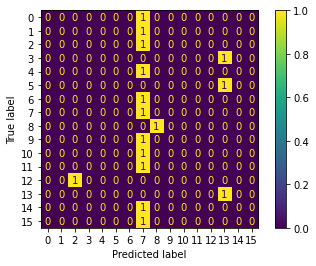

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

S_arr = S.numpy()
ConfusionMatrixDisplay.from_predictions(
    y_true=np.arange(BATCH_SIZE), y_pred=np.argmax(S_arr, axis=1))

Indeed, ideally the predictions should be on the diagonal. This means that the "default" space for this metric learning problem is not that good. We are ready to learn a new representation distribution.

In [ ]:
class DensePassageRetriever(keras.Model):

    def __init__(self, model_q, model_p):
        super().__init__()
        self.enc = DenseEncoder(model_q, model_p)

    def call(self, inputs, training=False):
        if training:
            # During training, we return the similarity matrix
            repr_q, repr_p = self.enc(inputs, training=training)
            S = tf.tensordot(q_repr, tf.transpose(p_repr), axes=1)
            return S
        else:
            # TODO
            repr_q = self.enc(inputs, training=training)
            return repr_q

    def train_step(self, data):
        # Custom train step to create ground truth labels on-the-fly
        with tf.GradientTape() as tape:
            # Obtain similarities
            S = self(data, training=True)
            # Create labels (0,1,2,...,BATCH_SIZE-1)
            labels = tf.range(BATCH_SIZE)
            # Obtain loss value
            loss = self.compiled_loss(labels, S)
        # Construct gradients and apply them through the optimizer
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Update and return metrics (specifically the one for the loss value).
        self.compiled_metrics.update_state(labels, S)
        return {m.name: m.result() for m in self.metrics}

def create_model(model_q, model_p, batch_size=BATCH_SIZE):
    model = DensePassageRetriever(model_q, model_p)
    # Compile the model and loss
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    )
    return model

# Test if it works
model = create_model(model_q, model_p, batch_size=BATCH_SIZE)
history = model.fit(dataset, shuffle=True, epochs=1)

## Testing

We pre-compute the representations of the paragraphs. We save it on disk so that we don't need to re-compute it everytime.

In [ ]:
paragraphs_representations = np.empty(
    shape=(len(paragraphs), BERT_DIMENSIONALITY)
)
paragraphs_representations.shape

(18896, 768)

In [ ]:
for i, p in enumerate(tqdm(paragraphs)):
    paragraphs_representations[i] = model_p(tokenizer_bert(
        p['context'], return_tensors='tf', max_length = 512, 
        truncation = True, padding = 'max_length'
    )).last_hidden_state[0,0,:]
np.savetxt('paragraphs_representations.txt', paragraphs_representations, delimiter=',')

In [ ]:
paragraphs_representations = np.loadtxt('paragraphs_representations.txt', delimiter=',')